# XGBoost検討用nb

## Mount＆modjule import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
!pip install -U xgboost -q

# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=ad7b0436090cf2bbf57a863de1f1695ba414dbb092043d0d2d73ca3ededde25d
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=24a35da4605f59c29a492c2f6917d5ee31867e1fc2da9845011688c9da1ffcc0
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.5 MB/s eta 0:00:00


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')

In [4]:
print("train_shape:",df_train.shape)
display(df_train.head())
print("test_shape:",df_test.shape)
display(df_test.head())

train_shape: (26280, 92)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


test_shape: (8760, 91)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
0,2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## 前処理

In [5]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
temp_cols = [f"{c}_{t}" for c in cities for t in ["temp", "temp_min", "temp_max"]]

for df in (df_train, df_test):          # ★ 2 つとも回す
    for col in temp_cols:
        df[col] = df[col] - 273.15

print("train temp range :", df_train["seville_temp_min"].min(), df_train["seville_temp_min"].max())
print("test  temp range :", df_test ["seville_temp_min"].min(), df_test ["seville_temp_min"].max())


train temp range : -4.0 42.0
test  temp range : -3.0 42.0


## 特徴量エンジニアリング

In [6]:
# 季節性（spring:1,summer:2,autumn:3,winter:4）
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)

# テストデータにも
df_test["month"] = df_test["time"].dt.month
df_test["season"] = df_test["month"].apply(get_season)

In [7]:
# 時間帯（morning:1,afternoon:2,evening:3,night:4）

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day"] = df_test["hour"].apply(get_time_of_day)

In [8]:
# 時間帯：夜とそれ以外（night:1,others:0）

def get_time_of_day_only_night(hour):
    if 5 <= hour < 21:
        return 0
    else:
        return 1

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day_only_night"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day_only_night"] = df_test["hour"].apply(get_time_of_day)

In [9]:
# 週末フラグ

def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [5,6]:
      return 1
    else:
      return 2

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# テストデータにも
df_test["weekday"] = df_test["time"].dt.weekday
df_test["is_weekend"] = df_test["weekday"].apply(is_week_end)

In [10]:
# 発電量の和
generation_columns = [col for col in df_train.columns if 'generation' in col]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

In [11]:
# 発電量のうちの火力発電の構成比[fossil]再生可能エネルギー構成比[renewable]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

# --- ② 分子になる電源グループ ---
df_train["fossil_total"]     = (
        df_train["generation_fossil_gas"]
      + df_train["generation_fossil_hard_coal"]
      + df_train["generation_fossil_oil"]
)
df_test["fossil_total"]      = (
        df_test["generation_fossil_gas"]
      + df_test["generation_fossil_hard_coal"]
      + df_test["generation_fossil_oil"]
)

df_train["renewable_total"]  = (
        df_train["generation_hydro_pumped_storage_consumption"]
      + df_train["generation_hydro_run_of_river_and_poundage"]
      + df_train["generation_hydro_water_reservoir"]
      + df_train["generation_other_renewable"]
)
df_test["renewable_total"]   = (
        df_test["generation_hydro_pumped_storage_consumption"]
      + df_test["generation_hydro_run_of_river_and_poundage"]
      + df_test["generation_hydro_water_reservoir"]
      + df_test["generation_other_renewable"]
)

# --- ③ 比率を安全に計算（0 除算防止） ---
eps = 1e-6
df_train["fossil_share"]     = df_train["fossil_total"]    / (df_train["generation_sum"] + eps)
df_test["fossil_share"]      = df_test["fossil_total"]     / (df_test["generation_sum"]  + eps)

df_train["renewable_share"]  = df_train["renewable_total"] / (df_train["generation_sum"] + eps)
df_test["renewable_share"]   = df_test["renewable_total"]  / (df_test["generation_sum"]  + eps)

In [12]:
# 祝日と3連休
import holidays, numpy as np

es_holidays = holidays.Spain(years=[2015, 2016, 2017, 2018])

for df in (df_train, df_test):
    df["is_holiday"] = df["time"].dt.date.map(lambda d: 1 if d in es_holidays else 0)
    # 前後1日
    for s in [-1, 1]:
        df[f"hol_adj{s}"] = df["is_holiday"].shift(s).fillna(0)
    # 3連休以上を flag
    df["is_long_wend"] = (
        (df["is_holiday"].rolling(3, min_periods=1).sum() >= 2).astype(int)
    )

In [13]:
# ---------------------------目的変数との相関が-0.24あったバレンシアの気温差---------------------------
# valencia_temp_diff
df_train["valencia_temp_diff"] = df_train["valencia_temp_max"] - df_train["valencia_temp_min"]
df_test["valencia_temp_diff"] = df_test["valencia_temp_max"] - df_test["valencia_temp_min"]

In [14]:
# ---------------------------チュートリアルにあった快適気温との差(valenciaのみ)---------------------------
# temp_dev
COMFORT = 23.0
df_train["temp_dev"] = (df_train["valencia_temp"] - COMFORT).abs()
df_test["temp_dev"] = (df_test["valencia_temp"] - COMFORT).abs()

# 不快指数


In [15]:
# ---------------------------交差項---------------------------
# season×is_weekend
df_train["season_isweekend"] = df_train["season"] * df_train["is_weekend"]
df_test["season_isweekend"] = df_test["season"] * df_test["is_weekend"]

# time_of_day×is_weekend
df_train["time_of_day_isweekend"] = df_train["time_of_day"] * df_train["is_weekend"]
df_test["time_of_day_isweekend"] = df_test["time_of_day"] * df_test["is_weekend"]

In [16]:
# --------------------- fossil_shareやrenewable_shareの変化量：風・太陽が落ちると火力比率↑ → 価格急騰。---------------------------------
# fossil_share_diff1
# renewable_share_diff1
# fossil_share_dev7d
# renewable_share_dev7d
share_cols = ["fossil_share", "renewable_share"]

for df in (df_train, df_test):
    # ---- ① 1 時間前との差分 ----
    for col in share_cols:
        df[f"{col}_diff1"] = df[col] - df[col].shift(1)

    # ---- ② 7日(168h) 移動平均からのずれ ----
    window = 24*7       # 168
    for col in share_cols:
        roll_mean = df[col].rolling(window, min_periods=1).mean()
        df[f"{col}_dev7d"] = df[col] - roll_mean

In [17]:
# ---------------------------price actualのラグ特徴量---------------------------
# ステップ 1：時系列順にソート
df_train = df_train.sort_values("time").reset_index(drop=True)
df_test = df_test.sort_values("time").reset_index(drop=True)

# ステップ 2：df_train にラグ追加（shift）
df_train["price_actual_lag1"]   = df_train["price_actual"].shift(1)
df_train["price_actual_lag24"]  = df_train["price_actual"].shift(24)
df_train["price_actual_lag168"] = df_train["price_actual"].shift(168)

# NaNを含む行を除外（df_train のみ）
df_train = df_train.dropna(subset=["price_actual_lag1", "price_actual_lag24", "price_actual_lag168"])

# ステップ 3：df_test にラグ追加（train の末尾を参照）
train_price = df_train.set_index("time")["price_actual"]

# 時間差からラグ生成（NaNがあっても dropna しない！）
for lag in [1, 24, 168]:
    df_test[f"price_actual_lag{lag}"] = df_test["time"].apply(
        lambda t: train_price.get(t - pd.Timedelta(hours=lag), np.nan)
    )

# ※ここでは df_test.dropna() しない → 提出用行数は保たれる

# モデルで使う test データだけ mask で抽出（あとで予測に使う）
test_mask = df_test[["price_actual_lag1", "price_actual_lag24", "price_actual_lag168"]].notna().all(axis=1)

# ✅ 表示確認（trainのみ）
display(df_train[["price_actual","price_actual_lag1","price_actual_lag24"]])

,price_actual,price_actual_lag1,price_actual_lag24
168,67.70,73.14,73.73
169,61.05,67.70,70.99
170,59.61,61.05,68.30
171,58.65,59.61,64.22
172,58.40,58.65,63.53
...,...,...,...
26275,39.90,35.37,62.92
26276,39.54,39.90,62.10
26277,32.90,39.54,60.09
26278,23.85,32.90,55.85


In [18]:
# ---------------------------totalload_actualのラグ特徴量---------------------------
lags = [1,24,168]
lag_targets = ["total_load_actual","generation_sum"]
for df in (df_train,df_test):
  for col in lag_targets:
    for i in lags:
      new_col = f"{col}_lag{i}"
      df[new_col] = df[col].shift(1)
      print(new_col)
df_train.head()

total_load_actual_lag1
total_load_actual_lag24
total_load_actual_lag168
generation_sum_lag1
generation_sum_lag24
generation_sum_lag168
total_load_actual_lag1
total_load_actual_lag24
total_load_actual_lag168
generation_sum_lag1
generation_sum_lag24
generation_sum_lag168


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,renewable_share_dev7d,price_actual_lag1,price_actual_lag24,price_actual_lag168,total_load_actual_lag1,total_load_actual_lag24,total_load_actual_lag168,generation_sum_lag1,generation_sum_lag24,generation_sum_lag168
168,2015-01-08 23:00:00+00:00,546.0,571.0,4178.0,7280.0,383.0,398.0,658.0,831.0,6741.0,...,-0.104604,73.14,73.73,64.02,NaN,NaN,NaN,NaN,NaN,NaN
169,2015-01-09 00:00:00+00:00,516.0,566.0,3912.0,6774.0,370.0,392.0,628.0,942.0,6741.0,...,-0.098472,67.70,70.99,58.46,26788.0,26788.0,26788.0,28338.0,28338.0,28338.0
170,2015-01-09 01:00:00+00:00,508.0,455.0,3718.0,6349.0,372.0,956.0,631.0,882.0,6742.0,...,-0.077546,61.05,68.30,54.70,25146.0,25146.0,25146.0,27150.0,27150.0,27150.0
171,2015-01-09 02:00:00+00:00,509.0,369.0,3768.0,6078.0,373.0,1088.0,634.0,934.0,6743.0,...,-0.068615,59.61,64.22,54.91,23889.0,23889.0,23889.0,26577.0,26577.0,26577.0
172,2015-01-09 03:00:00+00:00,518.0,367.0,3707.0,5984.0,373.0,1027.0,636.0,799.0,6744.0,...,-0.073815,58.65,63.53,53.07,23046.0,23046.0,23046.0,26117.0,26117.0,26117.0


In [19]:
print("df_test shape:", df_test.shape)

df_test shape: (8760, 125)


## データ分割＆モデル実装

In [20]:
# 特徴量の整理

base_features = [
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    #'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
]

add_features = [
    "generation_biomass",
    "generation_fossil_brown_coal/lignite",
    #"valencia_wind_speed",
    "madrid_wind_speed",
    "bilbao_pressure",
    "bilbao_wind_speed",
    #"bilbao_clouds_all",
    "barcelona_pressure",
    "barcelona_wind_speed",
    "seville_pressure",
    "seville_wind_deg",

    #"season",
    "time_of_day",
    "is_weekend",
    #"is_holiday",
    #"is_long_wend",
    #'generation_sum',
    #"fossil_share",
    #"renewable_share",
    #"time_of_day_only_night",
    "valencia_temp_diff",
    "season_isweekend",
    "time_of_day_isweekend",
    "temp_dev",
    "fossil_share_diff1",
    "renewable_share_diff1",
    "fossil_share_dev7d",
    "renewable_share_dev7d",
    "price_actual_lag1",
    #"price_actual_lag24",
    #"price_actual_lag168",
    "total_load_actual_lag1",
    "total_load_actual_lag24",
    #"total_load_actual_lag168",
    "generation_sum_lag1",
    #"generation_sum_lag24",
    #"generation_sum_lag168"
]
"""
add_features = [
    "generation_sum_lag1",
    "generation_sum_lag24",
    "generation_sum_lag168"
]
"""
features = base_features + add_features

In [21]:
""" 初期パラ
params_xgb = {
    "objective":"reg:squarederror",
    "learning_rate":0.05,
    "max_depth":18,
    "n_estimators":5000,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "tree_method":"hist",
    "random_state":42,
    "eval_metric":"rmse"
}
"""

# フォーラムを見たパラメータ
params_xgb = {
    "objective":       "reg:squarederror",
    "learning_rate":   0.023378586570803068,
    "max_depth":       7,
    "n_estimators":    317,
    "subsample":       0.9665142871966073,
    "colsample_bytree":0.6519917349250606,
    "min_child_weight":1,
    "gamma":           0.02005153624696357,
    "lambda":          0.6361532102889825,  # L2 正則化
    "tree_method":     "hist",
    "random_state":    42,
    "eval_metric":     "rmse"
}


In [31]:
#-------------------------log1p変換-------------------------------
df_train["price_log"] = np.log1p(df_train["price_actual"])

In [34]:
# ------------------------------------------------------------
# XGBoost
# ------------------------------------------------------------
def run_xgb(df_train, train_mask, val_mask, features,tag,params_xgb):
    """複数の検証パターンでXGBoostを回すための関数
    Parameters
    ----------
    df_train : 学習用 DataFrame（特徴量列 + 'price_actual'）
    df_test   : 検証用 〃
    features: 学習に使う列名リスト
    tag      : ログに出力するラベル文字列
    params_xgb   : xgboost.XGBRegressor に渡すハイパーパラメータ辞書

    Returns
    -------
    model : 学習済み XGBRegressor
    rmse  : 検証 RMSE
    """
    X_tr = df_train.loc[train_mask, features]
    #y_tr = df_train.loc[train_mask, "price_actual"]
    y_tr = df_train.loc[train_mask, "price_log"]
    X_va = df_train.loc[val_mask,  features]
    #y_va = df_train.loc[val_mask,  "price_actual"]
    y_va = df_train.loc[val_mask,  "price_log"]
    # ← ここで “実スケール” の正解を別で取っておく
    y_va_act = df_train.loc[val_mask, "price_actual"]

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        verbose=False,
    )

    #pred_va = model.predict(X_va)
    pred_va_log = model.predict(X_va)
    # logを基のスケールに戻す
    pred_va = np.expm1(pred_va_log)

    mse = mean_squared_error(y_va_act, pred_va)
    rmse = np.sqrt(mse)
    print(f"[{tag}]  val RMSE = {rmse:.4f}")
    return model, rmse


In [35]:
# ------------------------------------------------------------------
# 複数モデルの学習→結果、モデル3が良さそう6/19
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# ① Train: 2015-01-01〜2016-12-31 / Val: 2017-01-01〜2017-12-31
# ------------------------------------------------------------------
mask_15_16 = df_train["time"].between("2015-01-01", "2016-12-31")
mask_17    = df_train["time"].between("2017-01-01", "2017-12-31")

model_1, rmse_1 = run_xgb(df_train,mask_15_16, mask_17, features, "Pattern-1", params_xgb)

"""
# ------------------------------------------------------------
# ②: 2 fold 構成にしたい場合は run_xgb を 2 回手動で回す
# ------------------------------------------------------------
mask_2015  = df_train["time"].between("2015-01-01", "2015-12-31")
mask_2016  = df_train["time"].between("2016-01-01", "2016-12-31")

# --- fold-A : 2015 → 2016 -----------------------------------
model_2a, rmse_2a = run_xgb(df_train, mask_2015,  mask_2016,
                            features, "Pattern-2-A", params_xgb)

# --- fold-B : 2015-16 → 2017 -------------------------------
model_2b, rmse_2b = run_xgb(df_train, mask_15_16, mask_17,
                            features, "Pattern-2-B", params_xgb)

# --- 2 fold 平均 RMSE・平均 best_ntree を採用 ---------------
rmse_2  = (rmse_2a + rmse_2b) / 2
print(f"[Pattern-2] 2-fold CV RMSE = {rmse_2:.4f}")

"""

# ------------------------------------------------------------------
# ③ Train: 2015-01-01〜2017-09-30 / Val: 2017-10-01〜12-31
# ------------------------------------------------------------------
mask_tr_3 = df_train["time"].between("2015-01-01", "2017-09-30")
mask_va_3 = df_train["time"].between("2017-10-01", "2017-12-31")

model_3, rmse_3 = run_xgb(df_train,mask_tr_3, mask_va_3,features,"Pattern-3",params_xgb)


# ------------------------------------------------------------------
# ④ Train: 2015-01-01〜2016-12-31（2015-08-01～2016-03-31を除く） / Val: 2017-01-01〜2017-12-31
# ------------------------------------------------------------------
# まず全期間（2015-01-01〜2016-12-31）のマスクを作成
mask_whole = df_train["time"].between("2015-01-01", "2016-12-31")

# カットしたい区間（2015-08-01〜2016-03-31）のマスク
mask_cut = df_train["time"].between("2015-08-01", "2016-03-31")

# “全期間” − “カット区間” ＝ 使いたい期間
mask_15_16 = mask_whole & ~mask_cut
mask_17    = df_train["time"].between("2017-01-01", "2017-12-31")

model_4, rmse_4 = run_xgb(df_train,mask_15_16, mask_17, features, "Pattern-4", params_xgb)


# ------------------------------------------------------------------
# ⑤ Train: 2015-01-01〜2016-12-31 / Val: 2017-01-01〜2017-06-30
# ------------------------------------------------------------------
mask_tr_5 = df_train["time"].between("2015-01-01", "2016-12-31")
mask_va_5 = df_train["time"].between("2017-01-01", "2017-06-30")

model_5,rmse_5 = run_xgb(df_train,mask_tr_5,mask_va_3,features,"Pattern-5",params_xgb)

[Pattern-1]  val RMSE = 3.9303
[Pattern-3]  val RMSE = 3.6845
[Pattern-4]  val RMSE = 3.9891
[Pattern-5]  val RMSE = 3.9336


In [37]:
"""
# ------------------------------------------------------------------
# バリデーション後、もったいないのですべてのデータをもって再学習
# ------------------------------------------------------------------
mask_all = df_train["time"].between("2015-01-01", "2017-12-31")
X_full = df_train.loc[mask_all, features]
y_full = df_train.loc[mask_all, "price_actual"]

model_full = xgb.XGBRegressor(**params_xgb)
model_full.fit(X_full, y_full)
"""
# ------------------------------------------------------------------
# バリデーション後、もったいないのですべてのデータをもって再学習 （2015-08-01～2016-03-31を除くVer）
# ------------------------------------------------------------------
mask_all =  (
    df_train["time"].between("2015-01-01", "2015-07-31") |
    df_train["time"].between("2016-04-01", "2016-12-31")
)
X_full = df_train.loc[mask_all, features]
#y_full = df_train.loc[mask_all, "price_actual"]
y_full = df_train.loc[mask_all, "price_log"]

model_full = xgb.XGBRegressor(**params_xgb)
model_full.fit(X_full, y_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6519917349250606, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.02005153624696357,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.6361532102889825,
             learning_rate=0.023378586570803068, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=317, n_jobs=None,
             num_parallel_tree=None, ...)

In [36]:
# ------------------------------------------------------------
# テスト予測：モデル3が一番良いかも。fullor1or3で。
# ------------------------------------------------------------
pred_test = model_full.predict(df_test[features]) # ここだけ、訓練したモデルに応じて変える

# -------------------対数log1p変換の結果を戻す--------------------------
pred_test = np.expm1(pred_test)
# ------------------------------------------------------------
# ファイルをダウンロード
# ------------------------------------------------------------
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo   # 3.9 から標準搭載

# ① まずは “現在の UTC 時刻” を取得
utc_now = datetime.now(timezone.utc)

# ② UTC → JST(+9) に変換して、日付部分だけ取り出す
today = utc_now.astimezone(ZoneInfo("Asia/Tokyo")).date()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred':pred_test
})

filename = input("ファイル名を入力してください")
submission.to_csv(f'submission_{today}_{filename}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}_{filename}.csv')

/tmp/ipython-input-36-1363994660.py:7: RuntimeWarning: overflow encountered in expm1
  pred_test = np.expm1(pred_test)


KeyboardInterrupt: Interrupted by user

## SHAPにて有効な特徴量算出

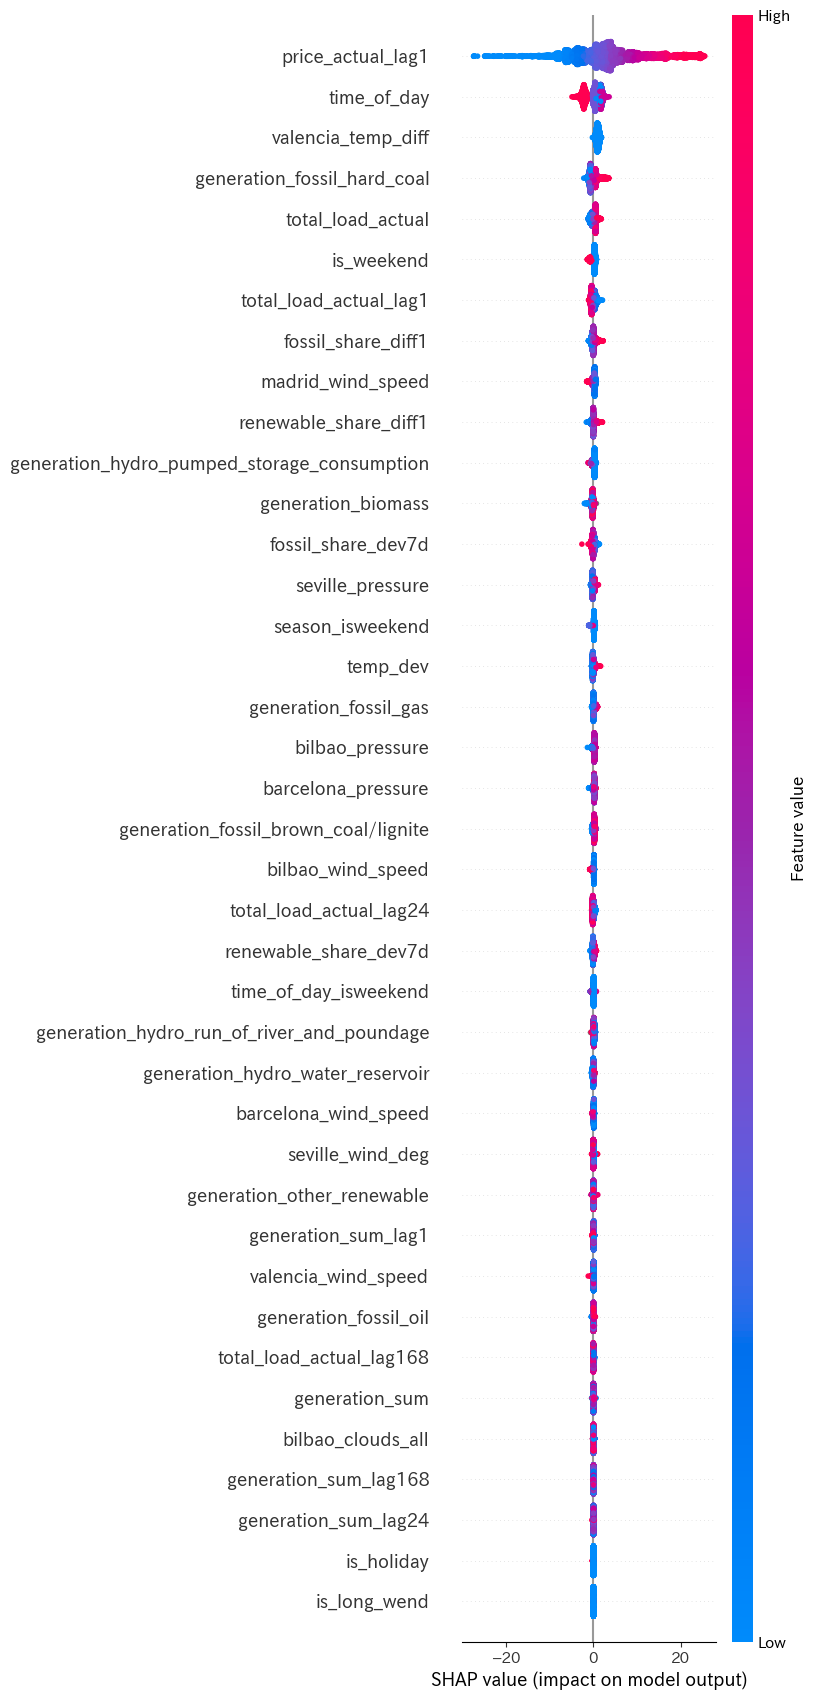

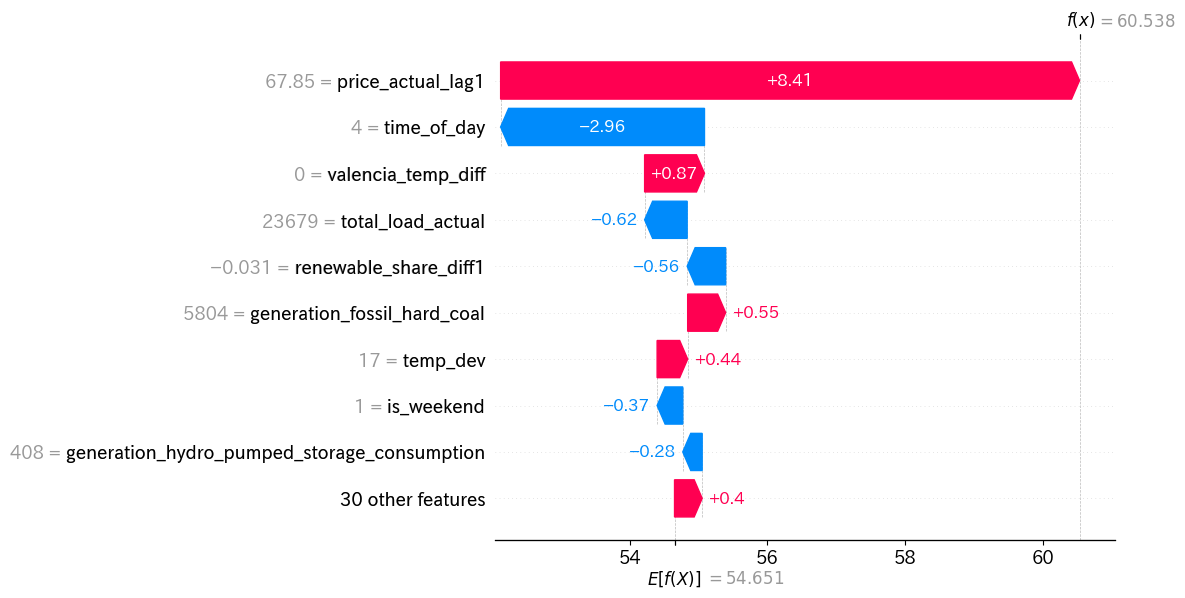

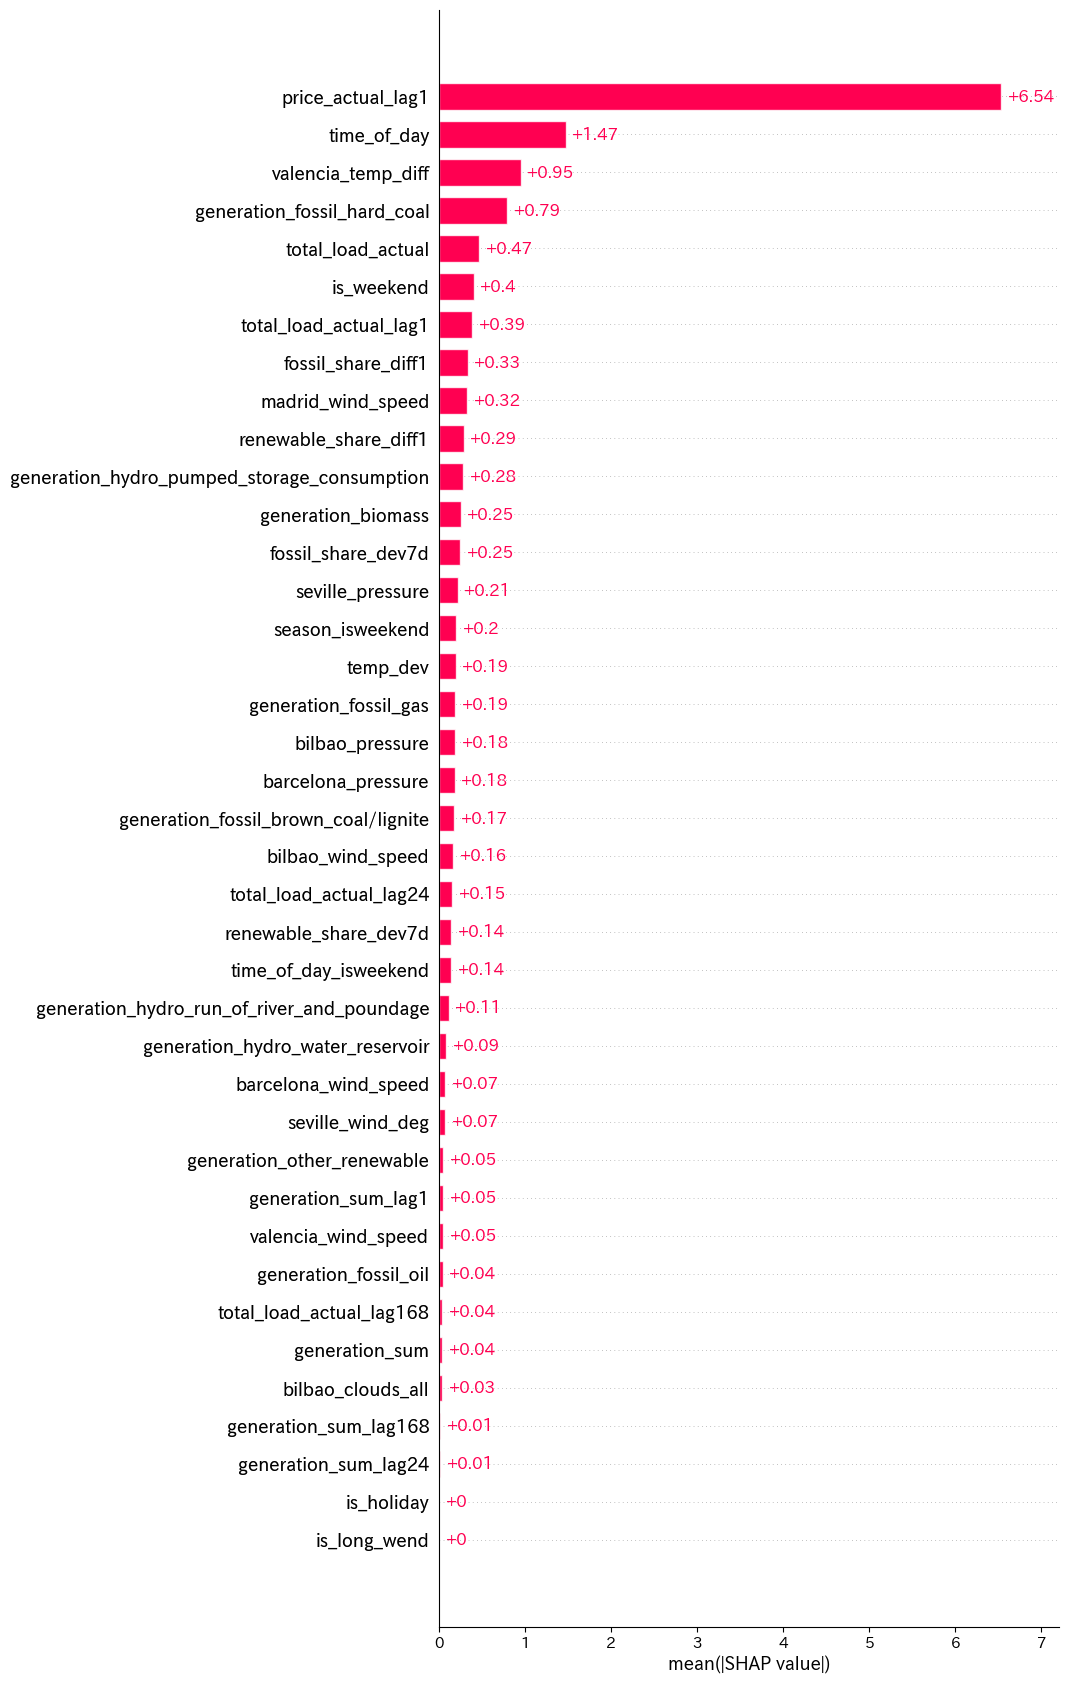

In [50]:
!pip install shap
import shap

# 評価表のx_valを再度作る（モデルに合わせる）　上記のパターン4にて特徴量の寄与度を測る
X_val = df_train.loc[mask_17, features]

# TreeSHAPの使用
explainer = shap.Explainer(model_4)
shap_values = explainer(X_val)

# 要約プロット（各特徴量の寄与度の分布を表示）
shap.summary_plot(shap_values, X_val, show=True, max_display=50)

# 特定のサンプル（例：最初の1件）の予測解釈
shap.plots.waterfall(shap_values[0])

# 絶対値をとる
shap.plots.bar(shap_values, max_display=50)

## 特徴量検証用

In [25]:
# ------------------------------------------------------------
# XGBoost 特徴量を一つずつ試して、効いているものを探る
# ------------------------------------------------------------
def feature_eval_loop(df_train, df_test,train_mask, val_mask, base_features, candidates, params_xgb):
    """
    base_features に対し、candidates を1つずつ追加しながらモデル評価を行う
    """
    from copy import deepcopy
    results = []

    for add in [None] + candidates:
        if add is None:
            current_features = deepcopy(base_features)
            tag = "Base only"
        else:
            current_features = deepcopy(base_features) + [add]
            tag = f"Add {add}"

        print(f"\n▶ Running with: {tag}")
        model, rmse = run_xgb(df_train, train_mask, val_mask, current_features, tag, params_xgb)

        results.append({
            "tag": tag,
            "features": current_features,
            "rmse": rmse
        })

    return pd.DataFrame(results)


# ------------------------------------------------------------------
# ① Train: 2015-01-01〜2016-12-31 / Val: 2017-01-01〜2017-12-31
# ------------------------------------------------------------------
mask_15_16 = df_train["time"].between("2015-01-01", "2016-12-31")
mask_17    = df_train["time"].between("2017-01-01", "2017-12-31")

# モデルを回す
df_result = feature_eval_loop(df_train, df_test, mask_15_16,mask_17 ,base_features, add_features, params_xgb)


▶ Running with: Base only
[Base only]  val RMSE = 12.3939

▶ Running with: Add generation_sum_lag1
[Add generation_sum_lag1]  val RMSE = 12.4984

▶ Running with: Add generation_sum_lag24
[Add generation_sum_lag24]  val RMSE = 12.4984

▶ Running with: Add generation_sum_lag168
[Add generation_sum_lag168]  val RMSE = 12.4984


## ラグ逐次変化のトライ

In [40]:
# ------------------------------------------------------------
# 逐次予測 (recursive forecasting) ― price_actual_lag1 を安全利用
# ------------------------------------------------------------
# 前提：df_train / df_test / features / model_full が既に定義済み
#       features には "price_actual_lag1" を含めておく
#       （lag24 / lag168 を使うなら同様に列名を追加）

from collections import deque

# --- バッファ初期化 ---
# raw（実スケール）用
last_act   = df_train.iloc[-1]["price_actual"]
buf24_act  = deque(df_train["price_actual"].tail(24).tolist(), maxlen=24)
# log（予測用）用
last_log   = df_train.iloc[-1]["price_log"]
buf24_log  = deque(df_train["price_log"].tail(24).tolist(),      maxlen=24)

pred_test_log = []

for _, row in df_test.sort_values("time").reset_index(drop=True).iterrows():
    row_feats = row.copy()
    # --- ① ラグは “実スケール” で渡す ---
    row_feats["price_actual_lag1"]   = last_act
    row_feats["price_actual_lag24"]  = buf24_act[-1]

    X_row = row_feats[features].astype(float).to_frame().T

    # --- ② 予測はログ空間で ---
    y_hat_log = model_full.predict(X_row)[0]
    pred_test_log.append(y_hat_log)

    # --- ③ バッファ更新 ---
    last_log  = y_hat_log
    buf24_log.append(y_hat_log)
    # 実スケールも更新
    last_act  = np.expm1(y_hat_log)
    buf24_act.append(last_act)

# --- ④ 一括で逆変換して提出用予測を作成 ---
pred_test = np.expm1(np.array(pred_test_log))

In [41]:
# 4) 提出ファイル作成

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    "pred": pred_test                 # 逐次予測した 8760 個
})
submission.to_csv("submission_recursive.csv", index=False, header=False)